In [163]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt


In [164]:
pd_train_data = pd.read_csv("Location446-30cls-5k.lrn.csv")
#pd_test_data_labels = pd.read_csv(path + '/' + all_files[1])
pd_test_data = pd.read_csv("Location446-30cls-5k.tes.csv")

pd_train_data_X = pd_train_data[pd_train_data.columns[2:]] # remove id and class
pd_test_data_X = pd_test_data[pd_test_data.columns[1:]] # remove id

pd_train_data_Y = pd_train_data[pd_train_data.columns[1]]


pd_train_data = pd_train_data[pd_train_data.columns[1:]]


In [5]:
#description of data
pd_train_data_X.describe()

,1,2,3,4,5,6,7,8,9,10,...,437,438,439,440,441,442,443,444,445,446
count,4000.000000,4000.000000,4000.000000,4000.0000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.056250,0.179250,0.048000,0.5310,0.096000,0.107000,0.030000,0.056750,0.162750,0.063500,...,0.036500,0.052000,0.042500,0.047500,0.060500,0.047000,0.202500,0.064750,0.124000,0.059750
std,0.230433,0.383609,0.213793,0.4991,0.294628,0.309152,0.170609,0.231393,0.369184,0.243891,...,0.187554,0.222055,0.201752,0.212732,0.238441,0.211665,0.401913,0.246115,0.329623,0.237053
min,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#checking for nan values
np.where(pd_train_data_X.count() != 4000)  #it seems that dataset does not contain any nan Values

for x in pd_train_data_X:
    if len(pd_train_data_X.groupby(['1']).size()) != 2:
        
        
        print('more thank 2 values in column')
        break
#it seemns that in each column are only two values

In [7]:
pd.DataFrame(pd_train_data_Y)

,class
0,11
1,3
2,9
3,8
4,3
...,...
3995,2
3996,27
3997,15
3998,19


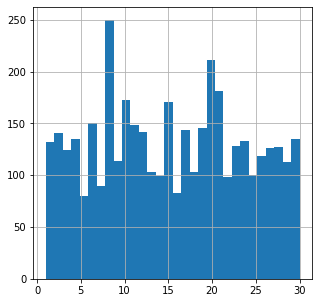

In [8]:
#class distribution
plt.figure()
ax = pd_train_data_Y.hist(figsize=(5,5),bins=30)
fig = ax.get_figure()
fig.savefig('location_notebook_output/loacation_class.png')

In [13]:
#try to over and under sample the data
bi = 120

def under_sample (pd_data, b = 100):
    value_keys = pd_data[pd_data.columns[0]].value_counts().to_dict()
    pd_new = pd.DataFrame()
    
    for key in value_keys.keys():
        loc = pd_data.loc[pd_data['class'] == key]

        if value_keys[key] > b:
            loc = loc.sample(n = b, replace = False)

        if len(pd_new) == 0:
            pd_new = loc
        else:
            pd_new = pd.concat((pd_new,loc),axis=0)
    
    pd_new = pd_new.sample(frac=1).reset_index(drop=True)

    
    pd_X = pd_new[pd_new.columns[1:]]
    pd_Y = pd_new[pd_new.columns[0]]
        
    return pd_X,pd_Y, pd_new


def over_sample(pd_data, b = 100):
    value_keys = pd_data[pd_data.columns[0]].value_counts().to_dict()
    pd_new = pd.DataFrame()
    
    for key in value_keys.keys():
        loc = pd_data.loc[pd_data['class'] == key]
        
        if value_keys[key] < b:
            
            app = loc.sample(n = (b - value_keys[key]), replace = False)
            
            loc = pd.concat((app,loc),axis=0)
            
        if len(pd_new) == 0:
            pd_new = loc
        else:
            pd_new = pd.concat((pd_new,loc),axis=0)
    
    pd_new = pd_new.sample(frac=1).reset_index(drop=True)

    
    pd_X = pd_new[pd_new.columns[1:]]
    pd_Y = pd_new[pd_new.columns[0]]
        
    return pd_X,pd_Y, pd_new
            

pd_X_under,pd_Y_under, pd_all_train_under = under_sample(pd_train_data, bi)

pd_X_under_over,pd_Y_under_over, pd_all_train_under_over = over_sample(pd_all_train_under, bi)

<AxesSubplot:>

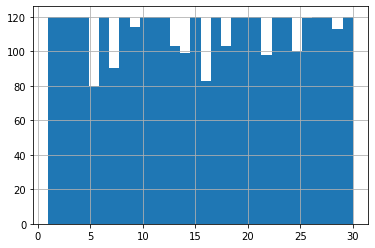

In [14]:
pd_Y_under.hist(bins=30)

<AxesSubplot:>

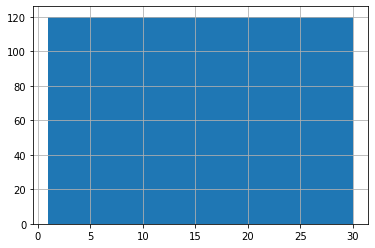

In [15]:
pd_Y_under_over.hist(bins=30)

In [168]:
pca = PCA(n_components=400)
pd_train_data = pca.fit_transform(pd_train_data_X)
pd_test_data = pca.transform(pd_test_data_X)


In [169]:
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5)
grid.fit(pd_train_data_X, pd_train_data_Y)
best_params = grid.best_params_
best_params

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [142]:
svm_clf = SVC( C= 10, gamma= 0.01, kernel= 'rbf')
svm_clf.fit(pd_train_data_X, pd_train_data_Y)
Predictions = svm_clf.predict(pd_test_data_X)

In [143]:
pd.DataFrame(svm_clf.predict(pd_test_data_X)).to_csv('resultsof200.csv')

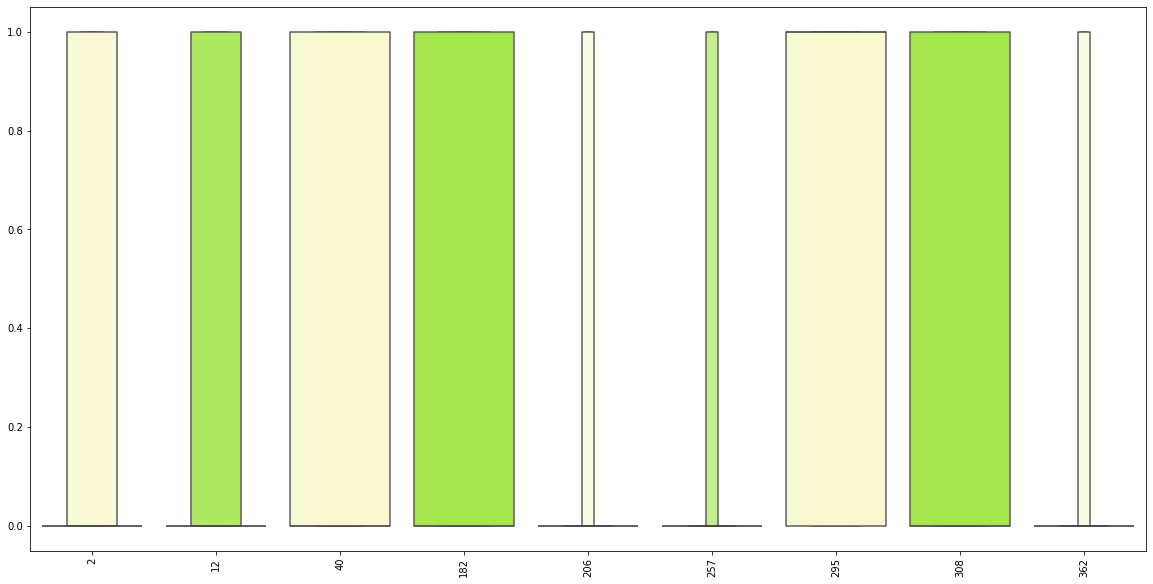

In [10]:
#pd_train = pd_train_data_X[['2','12','40','182','206','257','295','308','362']]
#pd_test  = pd_test_data_X[['2','12','40','182','206','257','295','308','362']]

#colours = ["#FFFFCB", "#AAFF32"]
#plt.figure(figsize=(20,10))
#sns.boxenplot(data = pd_train,palette = colours)
#plt.xticks(rotation=90)
#plt.show()


In [25]:
#model = RandomForestRegressor(random_state=1, max_depth=10)
#pd_train=pd.get_dummies(pd_train)
#prd=model.fit(pd_train,pd_train_data_Y)

In [27]:
#pkd=model.predict(pd_test)


#pd.DataFrame(model.predict(pd_test)).to_csv('finaltwo2.csv')


In [24]:
#data=pd.read_csv("solutons.csv")